In [1]:
# 고양이와 개 예제를 ImageDataGenerator, tf.data.Dataset을 이용해서
# 데이터를 생성하고 모델 학습하는 작업을 진행했어요!

# 추가적으로 TFRecord까지 알아보도록 할거에요!
# TFRecord는 tensorflow가 사용하는 표준적인 데이터 파일 포맷이에요!

# 결국 비전에서 사용하는 데이터 형태는
# 1. ImageDataGenerator
#    데이터 처리도 유연하지 않구요. 병렬처리도 그닥이에요!(시스템을 가려요)
#    IO 속도가 느려요! 대규모 데이터 처리에 부적합.
#    하지만 장점도 있는데 작성하기가 쉬워요! 작은 데이터에는 사용가능해요!
# 2. tf.data.Dataset
#    데이터 처리 유연성이 높아요!
#    IO 속도가 빨라요! 대규모 데이터 처리에 적합
# 3. tf.data.Dataset + TFRecord (가장 좋아요)
#    처리 유연성이 높아요! 병렬처리 지원
#    IO가 아주 빨라요

In [2]:
# 그럼 이제부터 알아봐야할 것은,
# 어떻게 하면 TFRecord를 만들 수 있는지에요!

# TFRecord를 알아보려면 먼저 Protocol Buffer부터 알아야 해요!
# Protocol Buffer는 Google에서 만든 이진 직렬화 방식이에요!
# 데이터를 더 작고, 빠르게 사용할 수 있도록 만들어 놓은 직렬화 방법

# 직렬화(Serialization) : 프로그램이 수행되면서 메모리 상에 객체라는 것들을
# 만들어서 사용하는데 당연히 메모리 공간이고 그 안에 데이터가 옹기종기 있어요!
# 이 메모리 안에 있는 데이터를 여러가지 방식을 통해 저장 가능한 형태로
# 다르게 표현하는 방법을 직렬화라고 해요!
# CSV, JSON, XML

In [3]:
# 결론적으로 쉽게 말하면
# 내가 가지고 있는 텍스트 데이터 혹은 이미지 파일같은 대용량의 데이터들을
# Protocol Buffer라는 직렬화 방법을 통해서 데이터의 형태를 변환시켜서
# 파일에 일정 형식으로 저장해 놓은 것 -> TFRecord

In [4]:
# 먼저 문서 편집기로 VS Code를 사용할거에요!
# student.proto 파일을 하나 생성해요!
# Protocol Buffer가 이진 직렬화를 하는 상당히 효율성이 높은
# 직렬화 방식인데 단점이 하나 있어요. 부가적인 파일이 하나 필요해요!
# 직렬화하려는 데이터를 표현하기 위해 객체의 뼈대에 대한 정보를
# 가지고 있어야 하는데 이 파일이 proto 파일이고 이 파일이 있어야해요!

# student.proto 파일은 jupyter_home 폴더안에 생성했어요!
# 이제 이 파일을 컴파일 할거에요!
# protoc student.proto --python_out=.

In [5]:
import student_pb2

student = student_pb2.Student()
student.name = 'Oh'
student.id = 20190710
student.dept = 'EE'
student.score = 3.98

serialized = student.SerializeToString()

with open('student.pb', 'wb') as f:
    f.write(serialized)

In [6]:
# 위의 코드를 이용하면 직렬화된 데이터를 가지고 있는 pb 파일을 만들 수 있어요!
# 이제 이 파일을 필요로 하는 사람한테 전달하면 되요!
# 그걸 받은 사람은 당연히 역직렬화해서 원해 데이터를 복원해서 사용하면 되요!

In [7]:
import student_pb2

student = student_pb2.Student() # 비어있는 객체

with open('student.pb', 'rb') as f:
    serialized = f.read() # 파일 안의 이진 데이터를 읽어들여요!
    student.ParseFromString(serialized)

print(student)

name: "Oh"
id: 20190710
dept: "EE"
score: 3.9800000190734863



In [8]:
# 간단하게 Protocol Buffer를 이용한 직렬화 방법에 대해서 알아보았어요!
# 1. 직렬화된 객체의 형태를 정의한 파일 => .proto (student.proto)
# 2. proto에 정의되어 있는 내용을 python에서 사용할거에요!
#    그래서 protoc라는 컴파일러를 이용해서 python에서 사용할 수 있는
#    proto차일을 생성한거에요. 이게 pb2.py 파일이에요!
# 3. 우리 python 코드에서 pb2 파일을 이용해서 직렬화할 객체를 생성
# 4. 우리 python 코드에서 객체를 직렬화 해요! => 파일에 저장
#    이 파일이 .pb 파일이에요!
# 5. 이 .pb 파일을 읽어들여서 역직렬화를 통해 원래 데이터를 복원

In [9]:
# 우리가 사용하려는 TFRecord는 이 Protocol Buffer를 이용하는 방식
# TFRecord는 Protocol Buffer를 이용해서 만든 직렬화된 데이터가
# 특수한 구조로 저장되어 있는 데이터 형식

# TFRecord는 Tensorflow의 표준 데이터 파일 포맷이에요!
# 내부에는 Protocol Buffer를 이용한 이진 직렬화 데이터가 들어가 있어요!

In [10]:
# TFRecord의 구조

# TFRecord
#   - Example 1
#   - Example 2
#   - Example 3
#   - ...

# 각각의 Example은 다음과 같이 구성되요!
# Example {
#     Features {
#         feature_name1 : Feature,
#         feature_name2 : Feature,
#         ...
#     }
# }

In [11]:
# 코드로 TFRecord를 한번 만들어 보아요!
# 1. 데이터를 먼저 준비해요!
# 2. 각 데이터를 Feature로 변환하고 이를 모은 Features를 생성해요!
# 3. Features를 이용해서 Example을 생성해요!
# 4. TFRecordWriter를 이용해서 Example 객체를 TFRecord 파일에 저장!

In [12]:
import tensorflow as tf

# 데이터 준비
image_data = b'x89PNG...' # 이미지 파일을 문자열로 읽은 데이터
label = 1
width = 300
height = 300

feature = {
    'image_raw' : tf.train.Feature(bytes_list=tf.train.BytesList(value=[image_data])),
    'label' : tf.train.Feature(int64_list=tf.train.Int64List(value=[label])),
    'width' : tf.train.Feature(int64_list=tf.train.Int64List(value=[width])),
    'height' : tf.train.Feature(int64_list=tf.train.Int64List(value=[height]))
}

example = tf.train.Example(features= tf.train.Features(feature=feature))

# Example 객체를 파일에 쓰면 되요!
with tf.io.TFRecordWriter('./test.tfrecord') as writer:
    writer.write(example.SerializeToString())

In [13]:
# 이렇게 작성된 TFRecord 파일을 읽어들일려면
# 1. 데이터 읽기 (Dataset 형태로 읽어요)
raw_dataset = tf.data.TFRecordDataset('test.tfrecord')

# 2. parsing 함수 정의 (어떻게 데이터를 복원할건지를 정의)
feature_description = {
    'image_raw' : tf.io.FixedLenFeature([], tf.string),
    'label' : tf.io.FixedLenFeature([], tf.int64),
    'width' : tf.io.FixedLenFeature([], tf.int64),
    'height' : tf.io.FixedLenFeature([], tf.int64)
}

def _parse_function(proto):
    return tf.io.parse_single_example(proto, feature_description)

dataset = raw_dataset.map(_parse_function,
                          num_parallel_calls=tf.data.AUTOTUNE)

for data in dataset:
    print(data)

{'height': <tf.Tensor: shape=(), dtype=int64, numpy=300>, 'image_raw': <tf.Tensor: shape=(), dtype=string, numpy=b'x89PNG...'>, 'label': <tf.Tensor: shape=(), dtype=int64, numpy=1>, 'width': <tf.Tensor: shape=(), dtype=int64, numpy=300>}


4000
['./data/cat_dog_tfrecord/dog.1097.jpg', './data/cat_dog_tfrecord/cat.1588.jpg', './data/cat_dog_tfrecord/dog.1953.jpg', './data/cat_dog_tfrecord/cat.672.jpg', './data/cat_dog_tfrecord/dog.1355.jpg']


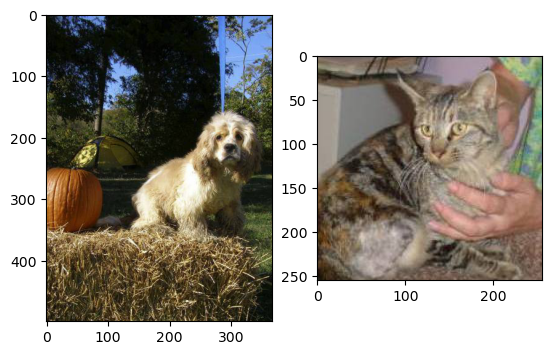

In [14]:
# 1. data/cat_dog_tfrecord/train 폴더를 생성합니다.
# 2. 개와 고양이 이진분류 문제에서 사용한 4000장의 이미지를
#    모두 복사해 위의 폴더에 붙여넣습니다.
# 3. 해당 폴더에서 이미지 2장만 선별하여 TFRecord로 저장해보고
# 4. 저장된 TFRecord에서 이미지 정보를 추출해 정상적으로
#    저장되었는지를 확인해보아요!
import numpy as np
from PIL import Image
import tensorflow as tf
import matplotlib.pyplot as plt
import warnings

# 경고를 보이지 않도록 설정해요!
warnings.filterwarnings('ignore')
# file 명을 알아와야 해요!
filenames = tf.io.gfile.glob('./data/cat_dog_tfrecord/*.jpg')
print(len(filenames))
print(filenames[:5])

# 이미지 2개의 그림을 그려보아요!
fig = plt.figure()
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)

img1 = Image.open(filenames[0])
img2 = Image.open(filenames[1])
ax1.imshow(img1)
ax2.imshow(img2)

plt.show()

In [15]:
# TFRecord로 이미지 데이터 저장!
# 이미지에 대한 pixel 데이터를 추출해서 TFRecord에 저장
# 단, resize하지 않고 원본 그대로 저장
# label도 파악해서 TFRecord에 넣을거구요, 이미지의 가로길이 세로길이도 넣을거에요!
# 이미지 파일의 이름도 TFRecord에 넣을거에요!
# 여러장의 이미지를 처리해야 되기 때문에 함수를 만들어서 사용.
# 함수는 이미지 1장에 대한 Example 객체를 리턴하도록 작성
# 나중에 이미지의 수만큼 for 문을 돌리면서 TFRecord에 Example 객체를 write하면 되요!

# 입력으로 들어온 이미지 1장에 대한 Example 객체를 만들어 리턴하는 함수
def to_example(filename):
    # filename => './data/cat_dog_tfrecord/dog.1097.jpg'
    image_string = tf.io.read_file(filename) # 파일 내용을 문자열로 가져와요!
    image_shape = tf.io.decode_jpeg(image_string).shape # (499, 367, 3)
    label = (filename.split('/')[-1]).split('.')[0] == 'dog' # True

    feature = {
        'image/height' : tf.train.Feature(int64_list=tf.train.Int64List(value=[image_shape[0]])),
        'image/width' : tf.train.Feature(int64_list=tf.train.Int64List(value=[image_shape[1]])),
        'image/label' : tf.train.Feature(int64_list=tf.train.Int64List(value=[label])), # 종속변수 (실제 학습에서 필요한 것)
        'image_raw' : tf.train.Feature(bytes_list=tf.train.BytesList(value=[image_string.numpy()])), # 독립변수 (실제 학습에서 필요한 것)
        'filename' : tf.train.Feature(bytes_list=tf.train.BytesList(value=[filename.encode()]))
    }
    return tf.train.Example(features=tf.train.Features(feature=feature))

tfrecords_path = './TFRecord_example.tfrecord'

with tf.io.TFRecordWriter(tfrecords_path) as writer:
    try:
        tf_example = to_example(filenames[0])
        writer.write(tf_example.SerializeToString())
        tf_example = to_example(filenames[1])
        writer.write(tf_example.SerializeToString())
    except:
        print('Error 발생')

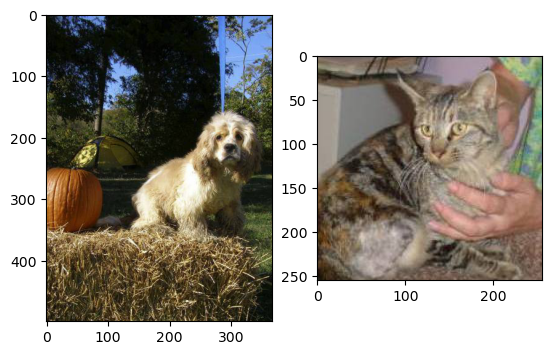

In [17]:
# 이렇게 이미지에 대한 여러가지 정보가 TFRecord에 저장되어 있어요!
# 이 데이터를 불러와서 이미지를 그려보아요!
# Dataset을 생성해야 해요!
raw_image_dataset = tf.data.TFRecordDataset(tfrecords_path)

# 데이터를 복구해야 해요!
feature_description = {
        'image/height': tf.io.FixedLenFeature([], tf.int64),
        'image/width': tf.io.FixedLenFeature([], tf.int64),
        'image/label': tf.io.FixedLenFeature([], tf.int64),
        'image_raw': tf.io.FixedLenFeature([], tf.string),
        'filename': tf.io.FixedLenFeature([], tf.string)
}
def _parse_function(proto):
    return tf.io.parse_single_example(proto, feature_description)

parsed_image_dataset = raw_image_dataset.map(_parse_function,
                                             num_parallel_calls=tf.data.AUTOTUNE)
fig = plt.figure()
axes = []

for i in range(2):
    axes.append(fig.add_subplot(1,2,i+1))

k = 0

import io

for image_feature in parsed_image_dataset:
    image_raw = image_feature['image_raw'].numpy() # byte array

    decode = np.array(Image.open(io.BytesIO(image_raw))) # 이미지에 대한 ndarray

    axes[k].imshow(decode)
    k += 1

plt.show()